In [1]:
#  Imports
from src.parsers import HMParser
from src.repairs import HMRepairPymoo
from src.scenes import HMProblemPymoo
from src.metrics import CommunityMetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

2024-01-02 15:08:18,295	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [8]:
# Multiply every resource by a factor of 10
# Always check for one dimensional arrays

new_data = copy.deepcopy(data)

# Generators
for key in new_data.generator.keys():

    # Check if the array is one dimensional
    if len(new_data.generator[key].shape) == 1:
        new_data.generator[key] = np.tile(new_data.generator[key], (10, ))
    else:
        # Add in n times
        new_data.generator[key] = np.tile(new_data.generator[key], (10, 1))

    # Add some noise to the GenActivePower
    if key == 'genActPower':
        new_data.generator[key] = new_data.generator[key] + np.random.normal(0, 0.1, len(new_data.generator[key])) if new_data.generator[key] > 0 else 0

# Loads
for key in new_data.load.keys():

    # Check if the array is one dimensional
    if len(new_data.load[key].shape) == 1:
        new_data.load[key] = np.tile(new_data.load[key], (10, ))
    else:
        # Add in n times
        new_data.load[key] = np.tile(new_data.load[key], (10, 1))

    # Add some noise to the LoadActivePower
    if key == 'loadActPower':
        new_data.load[key] = new_data.load[key] + np.random.normal(0, 0.1, len(new_data.load[key])) if new_data.load[key] > 0 else 0

# Storages
for key in new_data.storage.keys():

    # Check if the array is one dimensional
    if len(new_data.storage[key].shape) == 1:
        new_data.storage[key] = np.tile(new_data.storage[key], (10, ))
    else:
        # Add in n times
        new_data.storage[key] = np.tile(new_data.storage[key], (10, 1))

# EVs
for key in new_data.vehicle.keys():

    # Check if the array is one dimensional
    if len(new_data.vehicle[key].shape) == 1:
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (10, ))
    else:
        # Add in n times
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (10, 1))

# Increase the import and export maximum values by a factor of 10 to keep up
new_data.peers['import_contracted_p_max'] = new_data.peers['import_contracted_p_max'] * 10
new_data.peers['export_contracted_p_max'] = new_data.peers['export_contracted_p_max'] * 10

In [10]:
# Print the shapes of the data and new_data to check for consistency

print('Data shapes:')
print('Generators: \n')
for key in data.generator.keys():
    print(key, ': ', data.generator[key].shape)

print('\nLoads: \n')
for key in data.load.keys():
    print(key, ': ', data.load[key].shape)

print('\nStorages: \n')
for key in data.storage.keys():
    print(key, ': ', data.storage[key].shape)

print('\nEVs: \n')
for key in data.vehicle.keys():
    print(key, ': ', data.vehicle[key].shape)

print('\nNew data shapes:')
print('Generators: \n')
for key in new_data.generator.keys():
    print(key, ': ', new_data.generator[key].shape)

print('\nLoads: \n')
for key in new_data.load.keys():
    print(key, ': ', new_data.load[key].shape)

print('\nStorages: \n')
for key in new_data.storage.keys():
    print(key, ': ', new_data.storage[key].shape)

print('\nEVs: \n')
for key in new_data.vehicle.keys():
    print(key, ': ', new_data.vehicle[key].shape)

Data shapes:
Generators: 

p_forecast :  (7, 24)
cost_parameter_a :  (7, 24)
cost_parameter_b :  (7, 24)
cost_parameter_c :  (7, 24)
cost_nde :  (7, 24)
ghg_cof_a :  (7, 24)
ghg_cof_b :  (7, 24)
ghg_cof_c :  (7, 24)
internal_bus_location :  (7,)
type_generator :  (7,)
owner :  (7,)
manager :  (7,)
type_contract :  (7,)
p_max :  (7,)
p_min :  (7,)
q_max :  (7,)
q_min :  (7,)

Loads: 

p_forecast :  (6, 24)
q_forecast :  (6, 24)
p_reduce :  (6, 24)
p_move :  (6, 24)
p_in_move :  (6, 24)
cost_reduce :  (6, 24)
cost_cut :  (6, 24)
cost_mov :  (6, 24)
cost_ens :  (6, 24)
internal_bus_location :  (6,)
charge_type :  (6,)
owner_id :  (6,)
manager_id :  (6,)
type_contract :  (6,)
p_contracted :  (6,)
tg_phi :  (6,)

Storages: 

p_charge_limit :  (3, 24)
p_discharge_limit :  (3, 24)
charge_price :  (3, 24)
discharge_price :  (3, 24)
internal_bus_location :  (3,)
battery_type :  (3,)
owner :  (3,)
manager :  (3,)
type_contract :  (3,)
energy_capacity :  (3,)
energy_min_percentage :  (3,)
charge_

In [ ]:
# Pymoo imports for using DE

from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination

# Instantiate the DE algorithm
algorithm = DE(pop_size=20,
               sampling=LHS(),
               variant="DE/rand/1/bin",
               CR=0.3,
               dither="vector",
               jitter=False,
               repair=HMRepairPymoo(data=new_data))


# Set the termination criteria
termination = DefaultSingleObjectiveTermination(xtol=1e-8,
                                                cvtol=1e-6,
                                                ftol=1e-6,
                                                period=1000,
                                                n_max_gen=5e3,
                                                n_max_evals=5e9)

# Instantiate the problem
customProblem = HMProblemPymoo(data=new_data)

# Run the optimization
temp_res = minimize(customProblem,
                    algorithm,
                    termination=termination,
                    save_history=True,
                    verbose=True)

In [37]:
new_data.storage

{'p_charge_limit': array([[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
         10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
         10.0, 10.0],
        [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0,
         20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0,
         20.0, 20.0],
        [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
         4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0],
        [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
         10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
         10.0, 10.0],
        [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0,
         20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0,
         20.0, 20.0],
        [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
         4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0],
        [10.0, 1

In [4]:
# Objective function value

temp_res.F

array([243.92261321])

In [5]:
# Solution

decoded_resources = customProblem.decode(temp_res.X)

In [6]:
# Show the decoded resources

decoded_resources

{'genActPower': [genActPower_00,
  genActPower_01,
  genActPower_02,
  genActPower_03,
  genActPower_04,
  genActPower_05,
  genActPower_06],
 'genExcActPower': [genExcActPower_00,
  genExcActPower_01,
  genExcActPower_02,
  genExcActPower_03,
  genExcActPower_04,
  genExcActPower_05,
  genExcActPower_06],
 'pImp': pImp,
 'pExp': pExp,
 'loadRedActPower': [loadRedActPower_00,
  loadRedActPower_01,
  loadRedActPower_02,
  loadRedActPower_03,
  loadRedActPower_04,
  loadRedActPower_05],
 'loadCutActPower': [loadCutActPower_00,
  loadCutActPower_01,
  loadCutActPower_02,
  loadCutActPower_03,
  loadCutActPower_04,
  loadCutActPower_05],
 'loadENS': [loadENS_00,
  loadENS_01,
  loadENS_02,
  loadENS_03,
  loadENS_04,
  loadENS_05],
 'loadActPower': [loadActPower_00,
  loadActPower_01,
  loadActPower_02,
  loadActPower_03,
  loadActPower_04,
  loadActPower_05],
 'storDchActPower': [storDchActPower_00,
  storDchActPower_01,
  storDchActPower_02],
 'storChActPower': [storChActPower_00, storCh

In [7]:
# Metrics

metric = CommunityMetrics()
print(metric)

Community Metrics available: 
- self_consumption
- total_produced
- total_consumed
- import_export_balance



In [8]:
# Check the metrics
metric.cmd_self_consumption(production=decoded_resources['genActPower'],
                            consumption=decoded_resources['loadActPower'])

0.6314645726517113

In [9]:
# Do a list of metrics at once

metric.check_metrics_2inputs(components_a=decoded_resources['genActPower'],
                             components_b=decoded_resources['loadActPower'],
                             metric_list=['self_consumption'])

{'self_consumption': 0.6314645726517113}

In [10]:
# Try to get an error
# Total consumption is not a valid metric with two components

metric.check_metrics_2inputs(components_a=decoded_resources['genActPower'],
                             components_b=decoded_resources['loadActPower'],
                             metric_list=['self_consumption',
                                          'total_consumed'])

The requested metric is not available with provided inputs:  total_consumed


{'self_consumption': 0.6314645726517113, 'total_consumed': None}

In [18]:
# Do note that the following metrics do not make sense to be called like this.
# Use at own discretion

metric.check_metrics_1input(decoded_resources['loadActPower'],
                            metric_list=['total_consumed'])

{'total_consumed': 342.4098855999999}

In [19]:
# Calculate the self sufficiency of the community

production_list = ['genActPower', 'loadCutActPower', 'loadRedActPower', 'loadENS',
                   'storDchActPower', 'v2gDchActPower']

consumption_list = ['genExcActPower', 'loadActPower', 'storChActPower',
                    'v2gChActPower']

# Append all the production values to a single array. Need to go a level deeper
community_productions = np.array([decoded_resources[prod][prod_elem]
                                  for prod in production_list
                                  for prod_elem in range(len(decoded_resources[prod]))])
community_productions = np.append(community_productions, decoded_resources['pImp'])

# Same for the consumption values
community_consumptions = np.array([decoded_resources[cons][cons_elem]
                                   for cons in consumption_list
                                   for cons_elem in range(len(decoded_resources[cons]))])
community_consumptions = np.append(community_consumptions, decoded_resources['pExp'])

print('Self consumption: ', metric.cmd_self_consumption(community_productions, community_consumptions))
print('Cost: ', metric.cmd_energy_costs(community_productions[:-1], community_consumptions[:-1]))

Self consumption:  1.0000000000000002
Cost:  29.53293996737807


In [20]:
# Pymoo imports

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

algorithm_ga = GA(pop_size=100,
                  repair=HMRepairPymoo(data=data))

# Note that the problem and termination are the same as before
temp_res_ga = minimize(customProblem,
                       algorithm_ga,
                       termination=termination,
                       save_history=False,
                       verbose=True)

100
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  2.342689E+04 |  1.141072E+03
100
     2 |      200 |  1.323409E+03 |  1.042514E+03
100
     3 |      300 |  1.204266E+03 |  8.898486E+02
100
     4 |      400 |  1.085407E+03 |  8.614457E+02
100
     5 |      500 |  9.872732E+02 |  7.631919E+02
100
     6 |      600 |  8.978549E+02 |  7.041087E+02
100
     7 |      700 |  8.128933E+02 |  6.747107E+02
100
     8 |      800 |  7.527390E+02 |  6.173885E+02
100
     9 |      900 |  7.094640E+02 |  5.803015E+02
100
    10 |     1000 |  6.659510E+02 |  5.427310E+02
100
    11 |     1100 |  6.222118E+02 |  5.397202E+02
100
    12 |     1200 |  5.822588E+02 |  4.948615E+02
100
    13 |     1300 |  5.526805E+02 |  4.871881E+02
100
    14 |     1400 |  5.302777E+02 |  4.708961E+02
100
    15 |     1500 |  5.117821E+02 |  4.530397E+02
100
    16 |     1600 |  4.946115E+02 |  4.530397E+02
100
    17 |     1700 |  4.778205E+02 |  4.412129E+02
100
    18 |     1800 |  4.65044

In [21]:
# Do the same thing for the GA solutions

decoded_resources_ga = customProblem.decode(temp_res_ga.X)

community_productions_ga = np.array([decoded_resources_ga[prod][prod_elem]
                                     for prod in production_list
                                     for prod_elem in range(len(decoded_resources_ga[prod]))])
community_productions_ga = np.append(community_productions_ga, decoded_resources_ga['pImp'])

# Same for the consumption values
community_consumptions_ga = np.array([decoded_resources_ga[cons][cons_elem]
                                      for cons in consumption_list
                                      for cons_elem in range(len(decoded_resources_ga[cons]))])
community_consumptions_ga = np.append(community_consumptions_ga, decoded_resources['pExp'])

print('Self consumption: ', metric.cmd_self_consumption(community_productions_ga, community_consumptions_ga))
print('Cost: ', metric.cmd_energy_costs(community_productions_ga[:-1], community_consumptions_ga[:-1]))

Self consumption:  0.8156187572691723
Cost:  17.672719266643725


In [22]:
# Plot the results of both algorithms side by side
# Build the DataFrames for an easy area visualization
# For this we'll consider the sum of each component over time

# DE
df_de_cons = pd.DataFrame({'loadActPower': np.sum(decoded_resources['loadActPower'][i].value
                                                  for i in range(len(decoded_resources['loadActPower']))),
                           'genExcActPower': np.sum(decoded_resources['genActPower'][i].value
                                                    for i in range(len(decoded_resources['genExcActPower']))),
                           'storChActPower': np.sum(decoded_resources['storChActPower'][i].value
                                                    for i in range(len(decoded_resources['storChActPower']))),
                           'v2gChActPower': np.sum(decoded_resources['v2gChActPower'][i].value
                                                   [i] for i in range(len(decoded_resources['v2gChActPower']))),
                           'pExp': decoded_resources['pExp']})
df_de_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_de_prod = pd.DataFrame({'genActPower': np.sum(decoded_resources['genActPower'][i].value
                                                 for i in range(len(decoded_resources['genActPower']))),
                           'loadCutActPower': np.sum(decoded_resources['loadCutActPower'][i].value
                                                     for i in range(len(decoded_resources['loadCutActPower']))),
                           'loadRedActPower': np.sum(decoded_resources['loadRedActPower'][i].value
                                                     for i in range(len(decoded_resources['loadRedActPower']))),
                           'loadENS': np.sum(decoded_resources['loadENS'][i].value
                                             for i in range(len(decoded_resources['loadENS']))),
                           'storDchActPower': np.sum(decoded_resources['storDchActPower'][i].value
                                                     for i in range(len(decoded_resources['storDchActPower']))),
                           'v2gDchActPower': np.sum(decoded_resources['v2gDchActPower'][i].value
                                                    for i in range(len(decoded_resources['v2gDchActPower']))),
                           'pImp': decoded_resources['pImp']})
df_de_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

# GA
df_ga_cons = pd.DataFrame({'loadActPower': np.sum(decoded_resources_ga['loadActPower'][i].value
                                                  for i in range(len(decoded_resources_ga['loadActPower']))),
                           'genExcActPower': np.sum(decoded_resources_ga['genActPower'][i].value
                                                    for i in range(len(decoded_resources_ga['genExcActPower']))),
                           'storChActPower': np.sum(decoded_resources_ga['storChActPower'][i].value
                                                    for i in range(len(decoded_resources_ga['storChActPower']))),
                           'v2gChActPower': np.sum(decoded_resources_ga['v2gChActPower'][i].value
                                                   [i] for i in range(len(decoded_resources_ga['v2gChActPower']))),
                           'pExp': decoded_resources_ga['pExp']})
df_ga_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_ga_prod = pd.DataFrame({'genActPower': np.sum(decoded_resources_ga['genActPower'][i].value
                                                 for i in range(len(decoded_resources_ga['genActPower']))),
                           'loadCutActPower': np.sum(decoded_resources_ga['loadCutActPower'][i].value
                                                     for i in range(len(decoded_resources_ga['loadCutActPower']))),
                           'loadRedActPower': np.sum(decoded_resources_ga['loadRedActPower'][i].value
                                                     for i in range(len(decoded_resources_ga['loadRedActPower']))),
                           'loadENS': np.sum(decoded_resources_ga['loadENS'][i].value
                                             for i in range(len(decoded_resources_ga['loadENS']))),
                           'storDchActPower': np.sum(decoded_resources_ga['storDchActPower'][i].value
                                                     for i in range(len(decoded_resources_ga['storDchActPower']))),
                           'v2gDchActPower': np.sum(decoded_resources_ga['v2gDchActPower'][i].value
                                                    for i in range(len(decoded_resources_ga['v2gDchActPower']))),
                           'pImp': decoded_resources_ga['pImp']})
df_ga_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

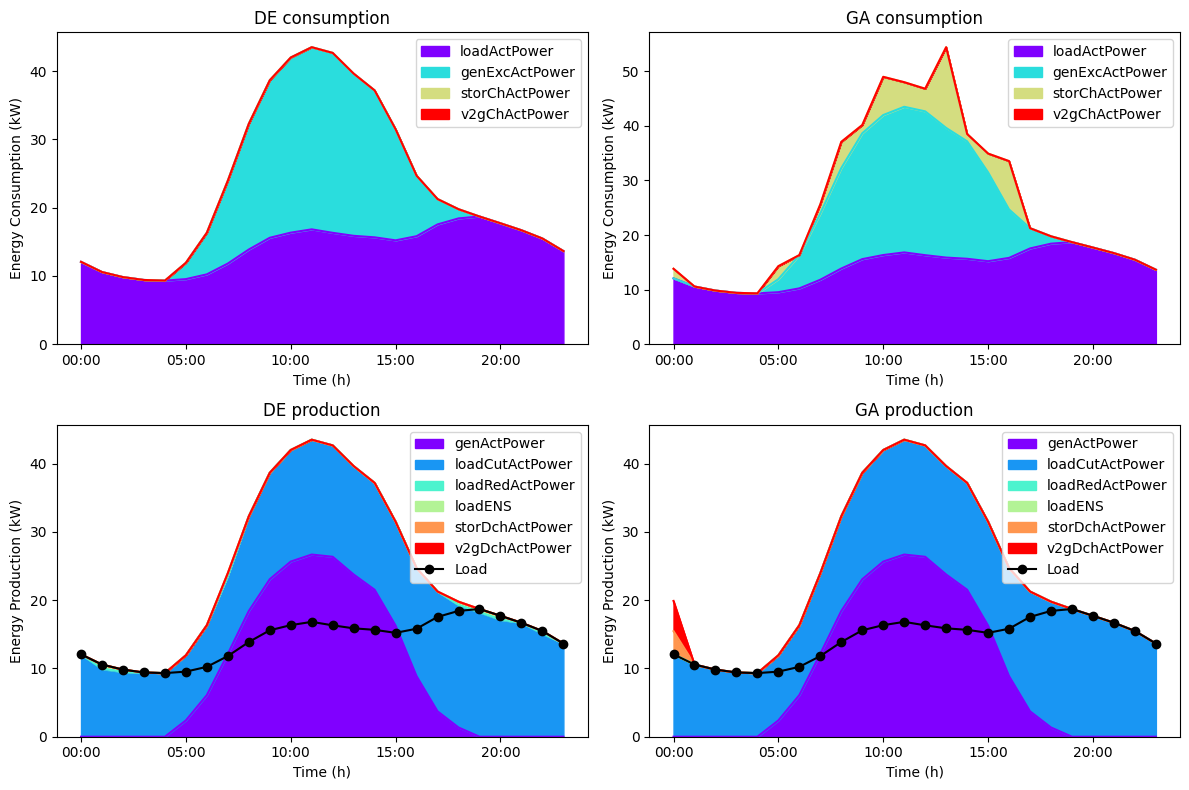

In [23]:
# Plot the results in an area graph

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the DE
df_de_cons.plot.area(ax=axs[0, 0], cmap='rainbow')
axs[0, 0].set_title('DE consumption')
axs[0, 0].set_ylabel('Energy Consumption (kW)')
axs[0, 0].set_xlabel('Time (h)')

df_de_prod.plot.area(ax=axs[1, 0], cmap='rainbow')
axs[1, 0].plot(np.sum(data.load['p_forecast'], axis=0), 'o-', label='Load', color='black')
axs[1, 0].legend()
axs[1, 0].set_title('DE production')
axs[1, 0].set_ylabel('Energy Production (kW)')
axs[1, 0].set_xlabel('Time (h)')

# Plot the GA
df_ga_cons.plot.area(ax=axs[0, 1], cmap='rainbow')
axs[0, 1].set_title('GA consumption')
axs[0, 1].set_ylabel('Energy Consumption (kW)')
axs[0, 1].set_xlabel('Time (h)')

df_ga_prod.plot.area(ax=axs[1, 1], cmap='rainbow')
axs[1, 1].plot(np.sum(data.load['p_forecast'], axis=0), 'o-', label='Load', color='black')
axs[1, 1].legend()
axs[1, 1].set_title('GA production')
axs[1, 1].set_ylabel('Energy Production (kW)')
axs[1, 1].set_xlabel('Time (h)')

plt.tight_layout()

plt.show()